## Import subtitles

In [1]:
import glob
import os
import sys

In [2]:
seasons = [1, 6, 7, 10]
seasons = [str(season) for season in seasons]

In [3]:
BASE_PATH = './friends-season-1/'
idcs = [str(_).zfill(2) for _ in range(1, 25)]
subtitles_data = []

for season in seasons:
    path = './data/friends-season-' + season + '/'
    for file in os.listdir(path):
        f = open(path + file, 'rb')
        content = f.read().decode('utf8', 'ignore')
        subtitles_data.append(content)

## Extracting only lines (대사) from the files

In [4]:
def extract_dialogue(file_content):
    dialogue = []
    lines = file_content.split('\r\n\r\n')
    for line in lines:
        dialogue.extend(line.split('\r\n')[2:])
    return dialogue

In [5]:
subtitles_lines = []
for content in subtitles_data:
    subtitles_lines.append(extract_dialogue(content))

In [6]:
from nltk.tokenize import word_tokenize

sentences = []
for subtitle_lines in subtitles_lines:
    # first three sentences and the last one are not to be used
    for line in subtitle_lines[3:-1]:
        sentences.append(word_tokenize(line))

In [7]:
len(sentences)

44902

## Word2Vec model

In [20]:
from gensim.models import Word2Vec
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

In [9]:
# example
# from nltk.corpus import movie_reviews
# sentences = [list(s) for s in movie_reviews.sents()]

In [10]:
%%time
model = Word2Vec(sentences)

CPU times: user 1.14 s, sys: 3.74 ms, total: 1.14 s
Wall time: 443 ms


In [11]:
model.init_sims(replace=True)

In [12]:
model.most_similar('Ross')

[('Chandler', 0.9538706541061401),
 ('Joey', 0.9502720832824707),
 ('Phoebe', 0.9453175663948059),
 ('Rachel', 0.9399054646492004),
 ('Pheebs', 0.9312976002693176),
 ('Rach', 0.9195692539215088),
 ('Hey', 0.9045003056526184),
 ('Yes', 0.9029451608657837),
 ('hey', 0.8963415026664734),
 ('Monica', 0.8882015943527222)]

## Visualize word2vec vectors

In [34]:
# visualization
from sklearn.manifold import TSNE
import pandas as pd
import re
import matplotlib.pyplot as plt

In [16]:
vocab = list(model.wv.vocab)
X = model[vocab]

In [17]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

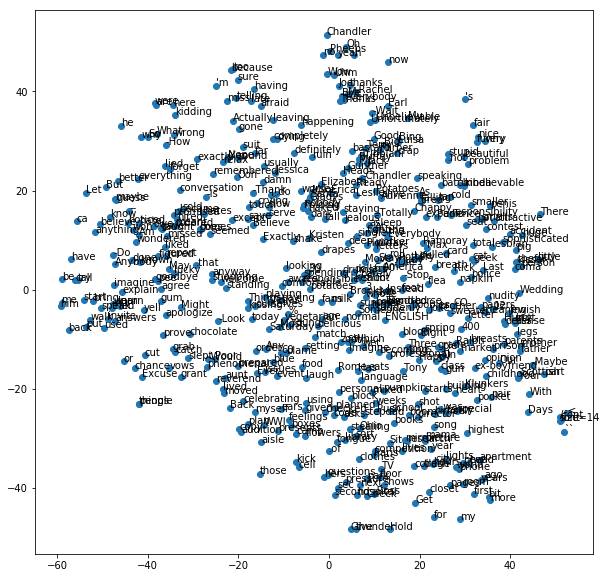

In [35]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df = df[:500]

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)

ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)